# Отчёт

**Задача**: в условиях ограниченных ресурсов  провести дообучение модели под домен.

**Имеющиеся ресурсы**: 2 GPU T4 (Kaggle)

**Домен**: новостные статьи  из русскоязычных источников на различную тематику (внутренняя политика, внешняя политика и т.д.)

При расмотрении основных моделей для работы с русским языком выбор пал на модель Saiga-Mistral от Ильи Гусева.</br>   В качестве причин такого выбора можно выделить следующие:</br> 


* Данная модель является адаптированной версией Mistral под работу с русским языком. Mistral использует механизм SWA (Sliding-Window-Attention), который позволяет уменьшить вычислительную сложность модели в зависимости от размера её контекстного окна
* Дополнительно используется Rolling Buffer Cache (фиксированный размер окна позволяет при генерации текста вытеснять из кэша декодировщика векторы, оказавшиеся за пределами контекста внимания)</br>
Всё это позволяет эффективно работать с большим контекстным окном и дообучать модель под домен/задачу с точки зрения вычислительных ресурсов.</br> 


Обучалась Saiga на следующих наборах данных с Hugging face.
- IlyaGusev/ru_sharegpt_cleaned
- IlyaGusev/oasst1_ru_main_branch
- IlyaGusev/ru_turbo_alpaca_evol_instruct
- lksy/ru_instruct_gpt4

Кроме того, количество её параметров (7 миллиардов), архитектура, а также использование различных техник "облегчения" LLM (о них поговорим далее) позволяет её дообучить в рамках имеющихся мощностей.

Llama-factory - фреймворк, позволяющий использовать передовые технологии глубокого обучения. С помощью него можно дообучать LLM под целевой домен, при этом серьёзно выигрывая в скорости обучения и объёме затрачиваемых вычислительных ресурсов. Ниже - сравнение использования фрейворка с другими проектами.

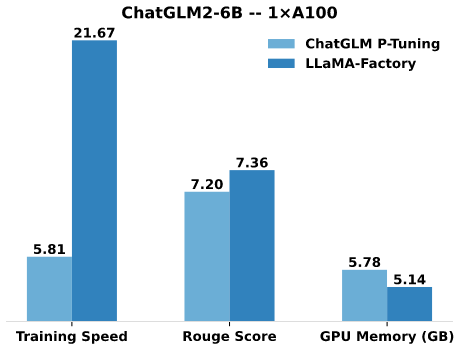

Установка Llama-factory

In [1]:
!git clone https://github.com/hiyouga/LLaMA-Factory.git

Cloning into 'LLaMA-Factory'...
remote: Enumerating objects: 12511, done.
remote: Counting objects: 100% (1292/1292), done.
remote: Compressing objects: 100% (552/552), done.
remote: Total 12511 (delta 883), reused 1026 (delta 723), pack-reused 11219
Receiving objects: 100% (12511/12511), 218.87 MiB | 28.00 MiB/s, done.
Resolving deltas: 100% (9132/9132), done.


In [2]:
!export CUDA_VISIBLE_DEVICES=0,1

In [3]:
%cd LLaMA-Factory
!pip install -r requirements.txt

/kaggle/working/LLaMA-Factory
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 1.6 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/opt/conda/lib/python3.10/site-packages/aiohttp-3.9.1.dist-info/METADATA'



In [4]:
!pip install  bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 13.3 MB/s eta 0:00:0000:0100:01


In [8]:
!nvidia-smi

Mon Jun  3 05:55:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Сделаем обе доступные карты видимыми для дальнейшей работы

In [12]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [14]:
import torch
torch.cuda.device_count()

2

# Загрузка набора данных

In [17]:
from datasets import load_dataset
import os
import json

dataset = load_dataset("IlyaGusev/gazeta", split = 'train[:2000]')

/opt/conda/lib/python3.10/site-packages/datasets/load.py:1486: FutureWarning: The repository for IlyaGusev/gazeta contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/IlyaGusev/gazeta
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Каким образом можно уменьшить вычислительную сложность для обучения моделей под домен?
1. LoRA - технология, которая позволяет дообучать так называемые "адаптеры", которые потом встраиваются в базовую модель. Таким образом, для дообучения LLM под конкретную задачу не нужно заново обучать всю модель, а обучить лишь небольшое число task-specific параметров, при этом заморозив остальные веса. В дальнейшем различные адаптеры (под конкретный домен/задачу) можно встраивать в модель, тем самым серьёзно снижая потребность в ресурсах/времени. Математически работу LoRA можно представить следующим образом: Мы можем представить матрицу ΔW в слое сети как произведение двух матриц A и B меньшей размерности, при этом сильно выиграем в количестве обучаемых параметров

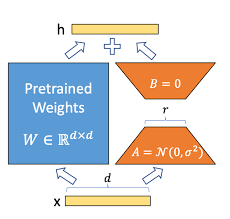

Обучаемые параметры здесь - матрицы А и В. Ниже - таблица, доказывающая эффективность использлвания LoRA в задачах NLP на примере модели GPT-3.

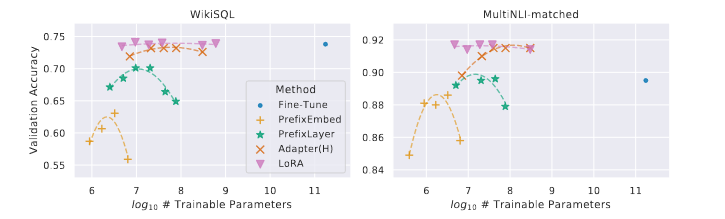

2. Квантование - метод оптимизации моделей глубокого обучения, при котором данные модели преобразуются из представления с плавающей запятой в представление с более низкой точностью.

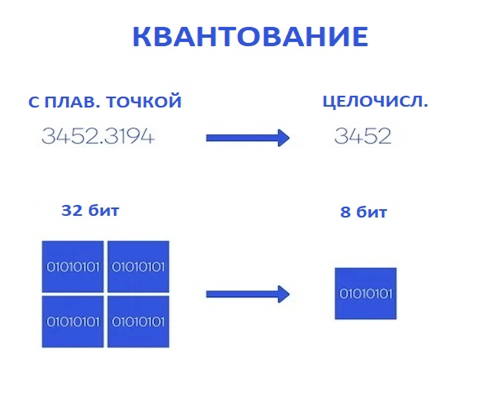

QLoRA - расширение LoRA, которое позволяет уменьшать точность весов в связке с технологией LoRA. Квантование позволяет серьёзно снизить вычислительную нагрузку на GPU во время обучения, а также объём памяти, необходимый для хранения и использования моделей. Ниже - график, показывающий эффективность квантования для уменьшения использования памяти.

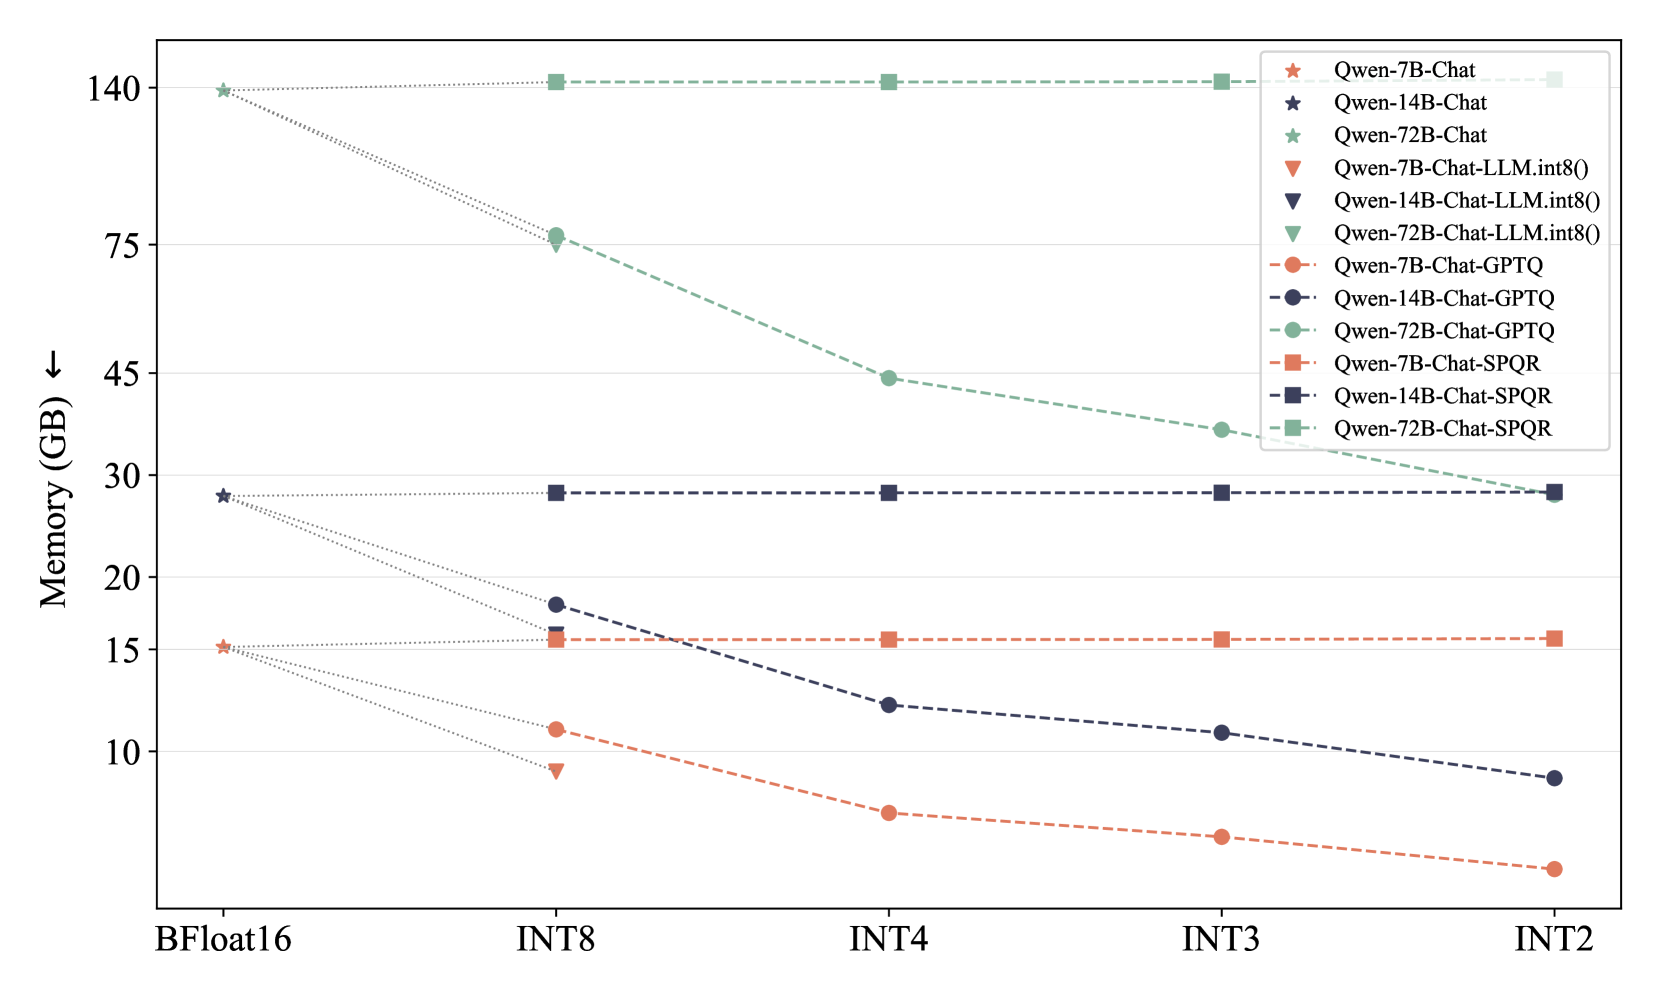

Для того, чтобы понять, какие возможности предоставляют ресурсы Kaggle для обучения моделей, были проведены небольшие тесты, результаты которых можно увидеть ниже.

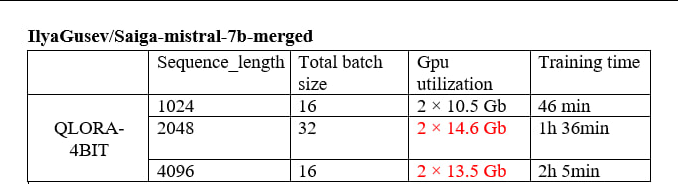

Из этих тестов видно, что ресурсы kaggle в связке с использованием QLoRA и Llama-factory вполне позволяют обучить модель Saiga с длиной контекста 2048 и 4096, используя при этом максимум ресурсов двух GPU T4. </br>
Без использования фреймворка время обучения возрастало в 2-3 раза.
Если использовать не QLoRA-4bit, а, например, QLoRA-8bit, то видеопамяти видеокарт не хватило бы даже на запуск обучения с длиной конктекста 512 и минимальным размером батча

In [ ]:
!wandb off

# Подготовим файл gazeta.json для его дальнейшего использования в Llama-factory

In [ ]:
save_path = "/kaggle/working/LLaMA-Factory/data"  
os.makedirs(save_path, exist_ok=True)
def save_as_json(data, filename):
    file_path = os.path.join(save_path, filename)
    data_to_save = [{
        "instruction": "Тебе на вход поступает русскоязычная статья из газеты. Твоя задача - выполнить суммаризацию этой статьи.",
        "input": data['text'][item],
        "output": data['summary'][item]
    } for item in range(len(dataset['text']))]
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(data_to_save, f, ensure_ascii=False, indent=4)

save_as_json(dataset, 'gazeta.json')
#save_as_json(dataset['validation'], 'validation.json')
#save_as_json(dataset['test'], 'test.json')

In [ ]:
%cd /kaggle/working/LLaMA-Factory/data

В репозитории Llama-factory есть уже предзагруженные наборы данных, добавим туда и набор данных Gazeta для его использования в LLama-factory

In [ ]:
%%writefile dataset_info.json
{
  "gazeta": {
    "file_name": "gazeta.json",
    "file_sha1": ""
  },
  "alpaca_en": {
    "file_name": "alpaca_data_en_52k.json",
    "file_sha1": "607f94a7f581341e59685aef32f531095232cf23"
  },
  "alpaca_zh": {
    "file_name": "alpaca_data_zh_51k.json",
    "file_sha1": "0016a4df88f523aad8dc004ada7575896824a0dc"
  },
  "alpaca_gpt4_en": {
    "file_name": "alpaca_gpt4_data_en.json",
    "file_sha1": "647f4ad447bd993e4b6b6223d1be15208bab694a"
  },
  "alpaca_gpt4_zh": {
    "file_name": "alpaca_gpt4_data_zh.json",
    "file_sha1": "3eaa3bda364ccdd59925d7448a698256c31ef845"
  },
  "identity": {
    "file_name": "identity.json",
    "file_sha1": "ffe3ecb58ab642da33fbb514d5e6188f1469ad40"
  },
  "oaast_sft": {
    "file_name": "oaast_sft.json",
    "file_sha1": "7baf5d43e67a91f9bbdf4e400dbe033b87e9757e",
    "columns": {
      "prompt": "instruction",
      "query": "input",
      "response": "output",
      "history": "history"
    }
  },
  "oaast_sft_zh": {
    "file_name": "oaast_sft_zh.json",
    "file_sha1": "a6a91f18f80f37b10ded9cf633fb50c033bf7b9f",
    "columns": {
      "prompt": "instruction",
      "query": "input",
      "response": "output",
      "history": "history"
    }
  },
  "lima": {
    "file_name": "lima.json",
    "file_sha1": "9db59f6b7007dc4b17529fc63379b9cd61640f37",
    "columns": {
      "prompt": "instruction",
      "query": "input",
      "response": "output",
      "history": "history"
    }
  },
  "glaive_toolcall": {
    "file_name": "glaive_toolcall_10k.json",
    "file_sha1": "a6917b85d209df98d31fdecb253c79ebc440f6f3",
    "formatting": "sharegpt",
    "columns": {
      "messages": "conversations",
      "tools": "tools"
    }
  },
  "example": {
    "script_url": "example_dataset",
    "columns": {
      "prompt": "instruction",
      "query": "input",
      "response": "output",
      "history": "history"
    }
  },
  "guanaco": {
    "hf_hub_url": "JosephusCheung/GuanacoDataset",
    "ms_hub_url": "AI-ModelScope/GuanacoDataset"
  },
  "belle_2m": {
    "hf_hub_url": "BelleGroup/train_2M_CN",
    "ms_hub_url": "AI-ModelScope/train_2M_CN"
  },
  "belle_1m": {
    "hf_hub_url": "BelleGroup/train_1M_CN",
    "ms_hub_url": "AI-ModelScope/train_1M_CN"
  },
  "belle_0.5m": {
    "hf_hub_url": "BelleGroup/train_0.5M_CN",
    "ms_hub_url": "AI-ModelScope/train_0.5M_CN"
  },
  "belle_dialog": {
    "hf_hub_url": "BelleGroup/generated_chat_0.4M",
    "ms_hub_url": "AI-ModelScope/generated_chat_0.4M"
  },
  "belle_math": {
    "hf_hub_url": "BelleGroup/school_math_0.25M",
    "ms_hub_url": "AI-ModelScope/school_math_0.25M"
  },
  "belle_multiturn": {
    "script_url": "belle_multiturn",
    "formatting": "sharegpt"
  },
  "ultra_chat": {
    "script_url": "ultra_chat",
    "formatting": "sharegpt"
  },
  "open_platypus": {
    "hf_hub_url": "garage-bAInd/Open-Platypus",
    "ms_hub_url": "AI-ModelScope/Open-Platypus"
  },
  "codealpaca": {
    "hf_hub_url": "sahil2801/CodeAlpaca-20k",
    "ms_hub_url": "AI-ModelScope/CodeAlpaca-20k"
  },
  "alpaca_cot": {
    "hf_hub_url": "QingyiSi/Alpaca-CoT",
    "ms_hub_url": "AI-ModelScope/Alpaca-CoT"
  },
  "openorca": {
    "hf_hub_url": "Open-Orca/OpenOrca",
    "ms_hub_url": "AI-ModelScope/OpenOrca",
    "columns": {
      "prompt": "question",
      "response": "response",
      "system": "system_prompt"
    }
  },
  "slimorca": {
    "hf_hub_url": "Open-Orca/SlimOrca",
    "formatting": "sharegpt"
  },
  "mathinstruct": {
    "hf_hub_url": "TIGER-Lab/MathInstruct",
    "ms_hub_url": "AI-ModelScope/MathInstruct",
    "columns": {
      "prompt": "instruction",
      "response": "output"
    }
  },
  "firefly": {
    "hf_hub_url": "YeungNLP/firefly-train-1.1M",
    "columns": {
      "prompt": "input",
      "response": "target"
    }
  },
  "wikiqa": {
    "hf_hub_url": "wiki_qa",
    "columns": {
      "prompt": "question",
      "response": "answer"
    }
  },
  "webqa": {
    "hf_hub_url": "suolyer/webqa",
    "ms_hub_url": "AI-ModelScope/webqa",
    "columns": {
      "prompt": "input",
      "response": "output"
    }
  },
  "webnovel": {
    "hf_hub_url": "zxbsmk/webnovel_cn",
    "ms_hub_url": "AI-ModelScope/webnovel_cn"
  },
  "nectar_sft": {
    "hf_hub_url": "mlinmg/SFT-Nectar",
    "ms_hub_url": "AI-ModelScope/SFT-Nectar"
  },
  "deepctrl": {
    "ms_hub_url": "deepctrl/deepctrl-sft-data"
  },
  "adgen": {
    "hf_hub_url": "HasturOfficial/adgen",
    "ms_hub_url": "AI-ModelScope/adgen",
    "columns": {
      "prompt": "content",
      "response": "summary"
    }
  },
  "sharegpt_hyper": {
    "hf_hub_url": "totally-not-an-llm/sharegpt-hyperfiltered-3k",
    "formatting": "sharegpt"
  },
  "sharegpt4": {
    "hf_hub_url": "shibing624/sharegpt_gpt4",
    "ms_hub_url": "AI-ModelScope/sharegpt_gpt4",
    "formatting": "sharegpt"
  },
  "ultrachat_200k": {
    "hf_hub_url": "HuggingFaceH4/ultrachat_200k",
    "ms_hub_url": "AI-ModelScope/ultrachat_200k",
    "columns": {
      "messages": "messages"
    },
    "tags": {
      "role_tag": "role",
      "content_tag": "content",
      "user_tag": "user",
      "assistant_tag": "assistant"
    },
    "formatting": "sharegpt"
  },
  "agent_instruct": {
    "hf_hub_url": "THUDM/AgentInstruct",
    "ms_hub_url": "ZhipuAI/AgentInstruct",
    "formatting": "sharegpt"
  },
  "lmsys_chat": {
    "hf_hub_url": "lmsys/lmsys-chat-1m",
    "ms_hub_url": "AI-ModelScope/lmsys-chat-1m",
    "columns": {
      "messages": "conversation"
    },
    "tags": {
      "role_tag": "role",
      "content_tag": "content",
      "user_tag": "human",
      "assistant_tag": "assistant"
    },
    "formatting": "sharegpt"
  },
  "evol_instruct": {
    "hf_hub_url": "WizardLM/WizardLM_evol_instruct_V2_196k",
    "ms_hub_url": "AI-ModelScope/WizardLM_evol_instruct_V2_196k",
    "formatting": "sharegpt"
  },
  "cosmopedia": {
    "hf_hub_url": "HuggingFaceTB/cosmopedia",
    "columns": {
      "prompt": "prompt",
      "response": "text"
    }
  },
  "oasst_de": {
    "hf_hub_url": "mayflowergmbh/oasst_de"
  },
  "dolly_15k_de": {
    "hf_hub_url": "mayflowergmbh/dolly-15k_de"
  },
  "alpaca-gpt4_de": {
    "hf_hub_url": "mayflowergmbh/alpaca-gpt4_de"
  },
  "openschnabeltier_de": {
    "hf_hub_url": "mayflowergmbh/openschnabeltier_de"
  },
  "evol_instruct_de": {
    "hf_hub_url": "mayflowergmbh/evol-instruct_de"
  },
  "dolphin_de": {
    "hf_hub_url": "mayflowergmbh/dolphin_de"
  },
  "booksum_de": {
    "hf_hub_url": "mayflowergmbh/booksum_de"
  },
  "airoboros_de": {
    "hf_hub_url": "mayflowergmbh/airoboros-3.0_de"
  },
  "ultrachat_de": {
    "hf_hub_url": "mayflowergmbh/ultra-chat_de"
  },
  "hh_rlhf_en": {
    "script_url": "hh_rlhf_en",
    "columns": {
      "prompt": "instruction",
      "response": "output",
      "history": "history"
    },
    "ranking": true
  },
  "oaast_rm": {
    "file_name": "oaast_rm.json",
    "file_sha1": "622d420e9b70003b210618253bd3d9d2891d86cb",
    "columns": {
      "prompt": "instruction",
      "query": "input",
      "response": "output",
      "history": "history"
    },
    "ranking": true
  },
  "oaast_rm_zh": {
    "file_name": "oaast_rm_zh.json",
    "file_sha1": "1065af1f3784dd61be5e79713a35f427b713a232",
    "columns": {
      "prompt": "instruction",
      "query": "input",
      "response": "output",
      "history": "history"
    },
    "ranking": true
  },
  "comparison_gpt4_en": {
    "file_name": "comparison_gpt4_data_en.json",
    "file_sha1": "96fa18313544e22444fe20eead7754b17da452ae",
    "ranking": true
  },
  "comparison_gpt4_zh": {
    "file_name": "comparison_gpt4_data_zh.json",
    "file_sha1": "515b18ed497199131ddcc1af950345c11dc5c7fd",
    "ranking": true
  },
  "nectar_rm": {
    "hf_hub_url": "mlinmg/RLAIF-Nectar",
    "ms_hub_url": "AI-ModelScope/RLAIF-Nectar",
    "ranking": true
  },
  "orca_dpo_de" : {
    "hf_hub_url": "mayflowergmbh/intel_orca_dpo_pairs_de",
    "ranking": true
  },
  "wiki_demo": {
    "file_name": "wiki_demo.txt",
    "file_sha1": "e70375e28eda542a90c68213640cc371898ce181",
    "columns": {
      "prompt": "text"
    }
  },
  "c4_demo": {
    "file_name": "c4_demo.json",
    "file_sha1": "a5a0c86759732f9a5238e447fecd74f28a66cca8",
    "columns": {
      "prompt": "text"
    }
  },
  "refinedweb": {
    "hf_hub_url": "tiiuae/falcon-refinedweb",
    "columns": {
      "prompt": "content"
    }
  },
  "redpajama_v2": {
    "hf_hub_url": "togethercomputer/RedPajama-Data-V2",
    "columns": {
      "prompt": "raw_content"
    },
    "subset": "default"
  },
  "wikipedia_en": {
    "hf_hub_url": "olm/olm-wikipedia-20221220",
    "ms_hub_url": "AI-ModelScope/olm-wikipedia-20221220",
    "columns": {
      "prompt": "text"
    }
  },
  "wikipedia_zh": {
    "hf_hub_url": "pleisto/wikipedia-cn-20230720-filtered",
    "ms_hub_url": "AI-ModelScope/wikipedia-cn-20230720-filtered",
    "columns": {
      "prompt": "completion"
    }
  },
  "pile": {
    "hf_hub_url": "EleutherAI/pile",
    "ms_hub_url": "AI-ModelScope/pile",
    "columns": {
      "prompt": "text"
    },
    "subset": "all"
  },
  "skypile": {
    "hf_hub_url": "Skywork/SkyPile-150B",
    "ms_hub_url": "AI-ModelScope/SkyPile-150B",
    "columns": {
      "prompt": "text"
    }
  },
  "the_stack": {
    "hf_hub_url": "bigcode/the-stack",
    "ms_hub_url": "AI-ModelScope/the-stack",
    "columns": {
      "prompt": "content"
    }
  },
  "starcoder_python": {
    "hf_hub_url": "bigcode/starcoderdata",
    "ms_hub_url": "AI-ModelScope/starcoderdata",
    "columns": {
      "prompt": "content"
    },
    "folder": "python"
  }
}

In [ ]:
%cd /kaggle/working/LLaMA-Factory
!wandb off


[We supported unsloth's implementation to boost LoRA tuning for the LLaMA, Mistral and Yi models.](https://github.com/hiyouga/LLaMA-Factory/blob/main/README.md)

In [ ]:
!pip install "unsloth[cu121] @ git+https://github.com/unslothai/unsloth.git"

Внесём изменения в конфигурационный файл single_config.yaml, для того, чтобы можно было использовать две видеокарты параллельно во время обучения на одном устройстве

In [ ]:
%%writefile single_config.yaml
compute_environment: LOCAL_MACHINE
debug: false
distributed_type: MULTI_GPU
downcast_bf16: 'no'
gpu_ids: all
machine_rank: 0
main_training_function: main
mixed_precision: fp16
num_machines: 1
num_processes: 2
rdzv_backend: static
same_network: true
tpu_env: []
tpu_use_cluster: false
tpu_use_sudo: false
use_cpu: false


In [ ]:
torch.cuda.empty_cache()

Запуск обучения

In [ ]:
!CUDA_VISIBLE_DEVICES=0,1 accelerate launch \
    --config_file single_config.yaml \
    ../../src/train_bash.py \
    --stage sft \
    --do_train \
    --model_name_or_path IlyaGusev/saiga_mistral_7b_merged \
    --dataset gazeta \
    --dataset_dir ../../data \
    --template default \
    --finetuning_type lora \
    --quantization_bit 4 \
    --lora_target all \
    --output_dir results \
    --cutoff_len 2048 \
    --use_unsloth True \
    --overwrite_cache \
    --per_device_train_batch_size 2 \
    --gradient_accumulation_steps 2 \
    --lr_scheduler_type cosine \
    --logging_steps 10 \
    --save_steps 1000 \
    --learning_rate 5e-5 \
    --num_train_epochs 2.0 \
    --output_dir ../../saves/Saiga-7b/QloRA-4bit/sft \
    --overwrite_output_dir True \
    --plot_loss \
    --fp16

Разберём основные параметры</br>
* do_train - выполняем обучение модели
* model_name_or_path - ссылка на репозиторий с Hugging face с базовой моделью, в нашем случае - saiga_mistral_7b_merged
* dataset - название набора данных, на котором будем обучать
* dataset_dir - путь до него
* template - шаблон для обучения. Llama-factory предлагает несколько типовых шаблонов для обучения моделей с разной архитектурой
* finetuning_type - используем LoRA
* quantization_bit - квантование весов
* lora_target - для каких доступных "модулей" применяем LoRA
* output_dir - директория для храрнения результатов обучения
* cutoff_len - максимальный размер входной последовательности
* per_device_train_batch_size - размер батча на GPU
* gradient_accumulation_steps - накапливание градиента для экономии видеопамяти
* lr_scheduler_type - регулирует скорость обучения между эпохами или итерациями по мере прохождения обучения
* fp16 - FP16 training (mixed precision), для ускорения обучения

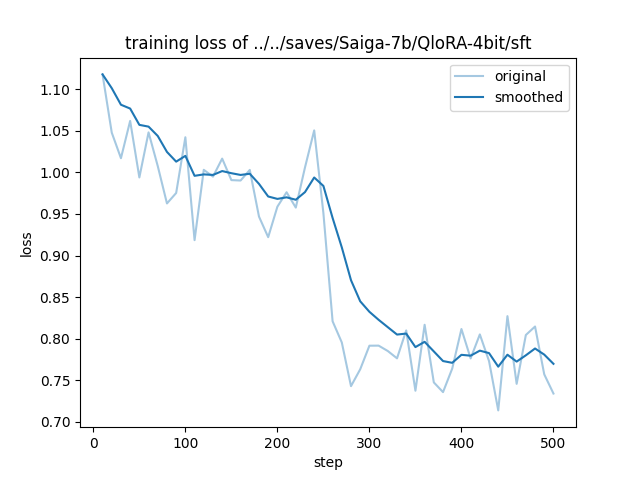

In [1]:
!pip install -q -U trl transformers accelerate git+https://github.com/huggingface/peft.git
!pip install -q datasets bitsandbytes einops wandb

# Посмотрим на результаты работы модели с контекстным окном 2048

In [49]:
from peft import PeftConfig, PeftModel
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

config = PeftConfig.from_pretrained("SouthMemphis/Saiga-lora-2048-2epochs")
model = AutoModelForCausalLM.from_pretrained(config.base_model_name_or_path, load_in_4bit=True, device_map="auto").eval()
model = PeftModel.from_pretrained(model, "SouthMemphis/Saiga-lora-2048-2epochs")


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [50]:
tokenizer = AutoTokenizer.from_pretrained("SouthMemphis/Saiga-lora-2048-2epochs")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.



Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
dataset['text'][12]

'Компания Google отказалась от использования на компьютерах своих сотрудников операционной системы Windows. Основная официальная претензия, которую выдвигает Google, – низкая безопасность детища Microsoft. «У нас больше не используется Windows: он недостаточно защищен», — заявил изданию Financial Times один из сотрудников Google. По данным газеты, компания решила оснастить почти 10 000 своих компьютеров другими системами, в частности Mac OS или Linux. Сотрудники, которые не желают переходить с Windows на иные системы, должны получить особое разрешение начальства. Решение об уходе с Windows было принято руководством Google ещё в январе и было связано с хакерскими атаками из Китая. С 2006 года, по соглашению с китайским правительством, Google фильтровал результаты поиска в стране, не давая пользователям находить неблагонадежные, с точки зрения официального Пекина, сайты. К таким страничками власти причислили адрес тибетского правительства в изгнании и правозащитных организаций, выступающ

In [7]:
eval_prompt = f"""Тебе на вход поступает русскоязычная статья из газеты. Твоя задача - выполнить суммаризацию этой статьи. Выдели из статьи наиболее релевантные фрагменты и по ним составь её суммаризацию.

### Статья:
{dataset['text'][12]}

### Её суммаризация:"""



In [21]:


model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    result = tokenizer.decode(model.generate(**model_input, max_new_tokens=600)[0], skip_special_tokens=False)
    eval_2 = result[result.find("Её суммаризация:") + len("Её суммаризация:") + 1:result.find("</s><s>")]
    print(eval_2)

Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.


Google переходит на Mac OS и Linux, так как Windows недостаточно защищен. Эксперты считают, что это первый пример в истории, когда крупная корпорация отказывается от операционной системы Microsoft. Потери Microsoft будут исключительно имиджевыми, считают эксперты.


**Метрики, используемые для оценки качества суммаризации**</br>
ROUGE (Recall-Oriented Understudy for Gisting Evaluation) – серия метрик, предложенная Chin-Yew Lin в 2004 для оценки качества решения задачи суммаризации текста.</br>
**Num words in reference** - общее число слов в target-суммаризации.</br>
**Num words in summary** - общее число слов, которое сгенерировала модель.</br>
**Num word mathes** - число слов, которое совпадает в сгенерированном моделью ответе и target-суммаризации

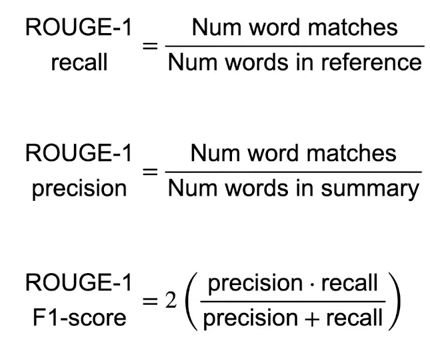

Аналогично определяется Rouge-2 (для биграмм)

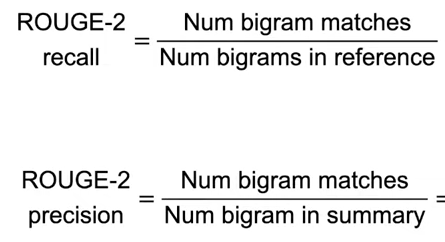

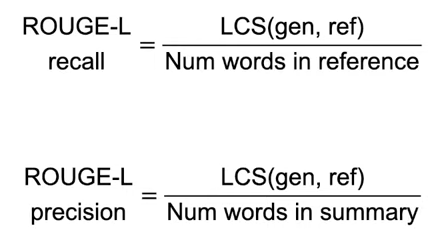

Где LCS(gen,ref) - максимальный размер последовательности слов, совпадающей в generated и target - суммаризации.

In [14]:
!pip install  rouge_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...



To disable this warning, you can either:



	- Avoid using `tokenizers` before the fork if possible



	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)








  Preparing metadata (setup.py) ... done





















  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=9a4f31e9badc36e6516a8acf6be5bc053f06134ba5e0921d64865a0c73f4c6b4



  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4



Successfully built rouge_score








In [22]:
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL', 'rougeLsum'])
scores = scorer.score(dataset['summary'][12], eval_2)
print(scores)

{'rouge1': Score(precision=0.8571428571428571, recall=0.6666666666666666, fmeasure=0.75), 'rouge2': Score(precision=0.3333333333333333, recall=0.25, fmeasure=0.28571428571428575), 'rougeL': Score(precision=0.7142857142857143, recall=0.5555555555555556, fmeasure=0.6250000000000001), 'rougeLsum': Score(precision=0.7142857142857143, recall=0.5555555555555556, fmeasure=0.6250000000000001)}


In [46]:
import pandas as pd
index_labels=['precision', 'recall', 'fmeasure']
table_for_first = pd.DataFrame(data=scores, index=index_labels)
table_for_first.index.name='Metric'

# Метрики модели до обучения

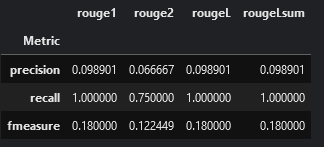

In [4]:
from IPython.display import Image
Image("C:/Users/yaroslav/Desktop/Снимок.PNG") 

# Метрики модели после обучения 

In [47]:
table_for_first

,rouge1,rouge2,rougeL,rougeLsum
Metric,,,,
precision,0.857143,0.333333,0.714286,0.714286
recall,0.666667,0.250000,0.555556,0.555556
fmeasure,0.750000,0.285714,0.625000,0.625000


# Примеры использования  модели

In [51]:
dataset['text'][2]

'После более чем 12-часовых консультаций Совет Безопасности ООН согласовал заявление председателя по израильскому штурму «Флотилии свободы». Совбез осудил захват флотилии, требует немедленно отпустить суда и призывает к проведению международного расследования инцидента, сообщает BBC со ссылкой на дипломатические источники. Экстренное заседание СБ ООН было созвано по инициативе Турции и Ливана после того, как израильские военные перехватили шесть судов шедшего в Газу гуманитарного конвоя. Согласно сообщению минобороны Израиля, при захвате погибли девять человек, ранены еще 33 человека. По информации посольства Израиля в Москве, в операции пострадали 10 израильских военных. В ходе открытого обсуждения Турция выступила с резкой критикой действий Израиля. «Попросту говоря, это равносильно бандитизму и пиратству. Это убийство, осуществленное руками государства», — заявил в ходе заседания турецкий министр иностранных дел Ахмет Давутоглу. «Эта флотилия была чем угодно, только не гуманитарной 

In [52]:
eval_prompt = f"""Тебе на вход поступает русскоязычная статья из газеты. Твоя задача - выполнить суммаризацию этой статьи. Выдели из статьи наиболее релевантные фрагменты и по ним составь её суммаризацию.

### Статья:
{dataset['text'][2]}

### Её суммаризация:"""


In [55]:
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    result = tokenizer.decode(model.generate(**model_input, max_new_tokens=600)[0], skip_special_tokens=False)
    eval = result[result.find("Её суммаризация:") + len("Её суммаризация:") + 1:result.find("</s><s>")]
    print(eval)

Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.


Совет Безопасности ООН осудил захват израильскими военными гуманитарной флотилии, требуя немедленно отпустить суда и провести международное расследование инцидента. Турция и Ливан созвали экстренное заседание Совбеза ООН, на котором Турция назвала действия Израиля «пиратством» и «убийством». Россия также осудила захват кораблей, заявив, что Израиль нарушил международное право. Израильские власти задержали 480 человек, из которых 48 планируется депортировать.


In [61]:
dataset['text'][27]

'Глава правительства Японии Юкио Хатояма официально объявил о намерении уйти в отставку, передает ИТАР-ТАСС со ссылкой на телеканал NCHK. О своем решении он уже уведомил возглавляемую им Демократическую партию Японии. Хатояма принес извинения избирателям за то, что не смог выполнить предвыборное обещание — вывести американскую базу Футэмма за пределы префектуры Окинава. «Я приношу извинения за то, что нам не удалось вывести базу Футэмма за пределы префектуры Окинава, но мы продолжим к этому стремиться», — заявил глава правительства. «В современных условиях японо-американское сотрудничество необходимо для обеспечения безопасности не только нашей страны, но и всего региона», — пояснил он. Вместе с премьер-министром решил уйти в отставку генеральный секретарь ДПЯ Итиро Одзава. Он выразил надежду, что благодаря усилиям партии в стране станет обязательно лучше, и пригласил Социал-демократическую партию, вышедшую из правящей коалиции 30 мая, вернуться к сотрудничеству. Перенос американской в

In [62]:
eval_prompt = f"""Тебе на вход поступает русскоязычная статья из газеты. Твоя задача - выполнить суммаризацию этой статьи. Выдели из статьи наиболее релевантные фрагменты и по ним составь её суммаризацию.

### Статья:
{dataset['text'][27]}

### Её суммаризация:"""

In [63]:
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    result = tokenizer.decode(model.generate(**model_input, max_new_tokens=600)[0], skip_special_tokens=False)
    eval = result[result.find("Её суммаризация:") + len("Её суммаризация:") + 1:result.find("</s><s>")]
    print(eval)

Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.


Премьер-министр Японии Юкио Хатояма объявил о намерении уйти в отставку. Он не смог выполнить обещание вывести американскую базу Футэмма за пределы префектуры Окинава. Вместе с Хатоямой уходит в отставку генеральный секретарь его партии Итиро Одзава. Политические круги Японии считают, что демократы решили «подкрасить фасад» перед выборами в верхнюю палату парламента.


In [67]:
dataset['text'][33]

'В России произошло второе самоубийство школьника в период сдачи ЕГЭ. В Москве в ночь на среду около 22.09 из окна седьмого этажа дома № 4 на Пулковской улице выпрыгнул 16-летний ученик московской школы № 224. Дом подростка и его школа находятся на станции метро «Водный стадион». 31 мая школьник сдавал обязательный госэкзамен по русскому языку. По факту самоубийства Следственный комитет по Москве (СКП) проводит доследственную проверку. Как рассказали «Газете.Ru» в пресс-службе ведомства, до госэкзамена школьник очень беспокоился о его результатах и «высказывал родителям мысли о суициде». По данным СКП, 1 июня между 21.00 и 22.00 подросток разговаривал с родителями и вновь сказал отцу, что собирается покончить с собой. Отец не дал школьнику выйти на улицу, разгорелась ссора. Подросток оттолкнул отца и бабушку, стоящих около него, вбежал в общую с младшей сестрой комнату и выпрыгнул с балкона. Префект САО Олег Митволь сказал «Газете.Ru», что, по информации из образовательных и правоохран

In [68]:
eval_prompt = f"""Тебе на вход поступает русскоязычная статья из газеты. Твоя задача - выполнить суммаризацию этой статьи. Выдели из статьи наиболее релевантные фрагменты и по ним составь её суммаризацию.

### Статья:
{dataset['text'][33]}

### Её суммаризация:"""

In [69]:
model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    result = tokenizer.decode(model.generate(**model_input, max_new_tokens=600)[0], skip_special_tokens=False)
    eval = result[result.find("Её суммаризация:") + len("Её суммаризация:") + 1:result.find("</s><s>")]
    print(eval)

Setting `pad_token_id` to `eos_token_id`:32000 for open-end generation.


Во время сдачи ЕГЭ в России произошло второе самоубийство школьника. В Москве 16-летний ученик сдавал экзамен по русскому языку и после его завершения выпрыгнул из окна на седьмом этаже. В СКП говорят, что подросток беспокоился о результатах экзамена и рассказывал родителям о намерении покончить с собой. Министерство образования заявляет, что самоубийство ученика не связано с ЕГЭ.
